Initialise  
Mid price - classification rather than, 
Label - neural network (Random Forest)
mid-price

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

Import data

In [3]:
data = pd.read_csv('UoB_Set01_2025-01-31LOBs.csv')
print(data.head())

       Time        Bid1        Bid2         Ask1         Ask2  Mid-Price  \
0  07:30:00      [0, 0]      [0, 0]       [0, 0]       [0, 0]       0.00   
1  07:30:01  [325.0, 1]      [0, 0]       [0, 0]       [0, 0]     162.50   
2  07:30:02  [325.0, 4]  [292.0, 2]  [724.38, 8]  [800.0, 15]     524.69   
3  07:30:03  [325.0, 1]  [292.0, 1]   [713.0, 1]   [800.0, 5]     519.00   
4  07:30:04  [325.0, 1]  [292.0, 1]   [713.0, 1]   [800.0, 5]     519.00   

   Total_volume  Bid_ask_spread  Order_imbalance  
0             0            0.00             0.00  
1             1         -325.00             1.00  
2            29          399.38            -0.59  
3             8          388.00            -0.50  
4             8          388.00            -0.50  


Split the data 80:20 by time

In [4]:
# Calculate the split index
split_index = int(len(data) * 0.8)

# Split the DataFrame into train and test sets based on the split index
train = data.iloc[:split_index]
test = data.iloc[split_index:]

Do ADF Test to check if data is stationary 

In [5]:
from statsmodels.tsa.stattools import adfuller
# Assuming `data` is a pandas Series of your time series data
result = adfuller(data['Order_imbalance'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[0] < result[4]["5%"]:
    print("Reject the null hypothesis - Data is stationary")
else:
    print("Fail to reject the null hypothesis - Data is not stationary")

ADF Statistic: -44.943939
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis - Data is stationary


Plot ACF

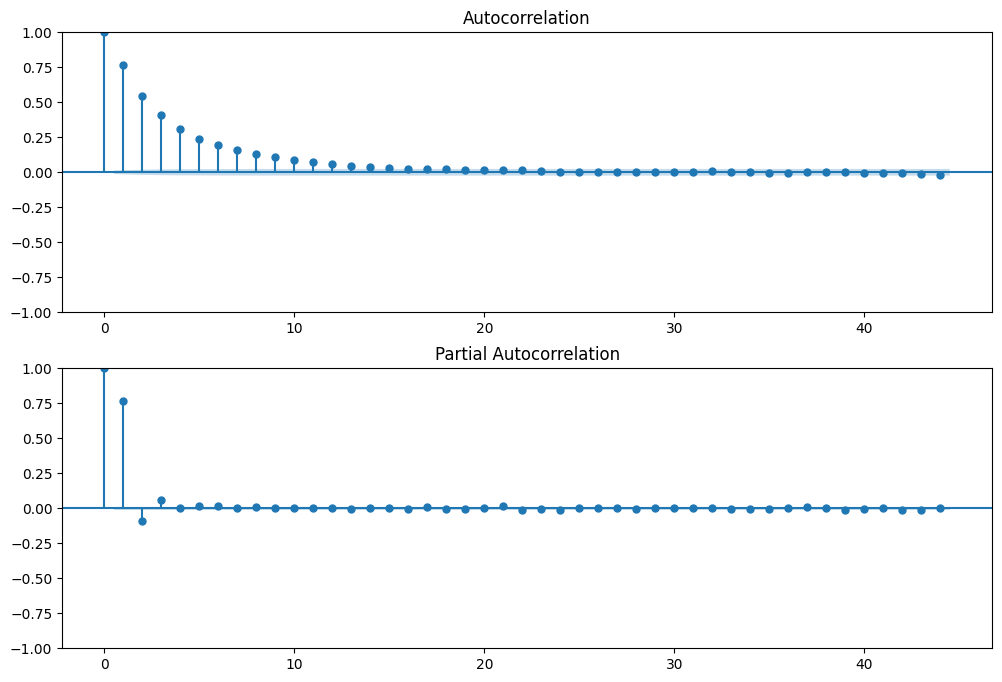

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Selecting the 'Mid-Price' column for ACF and PACF plots
train_mid_price = train['Order_imbalance']

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_mid_price, ax=ax[0])  # ACF plot for 'Mid-Price'
plot_pacf(train_mid_price, ax=ax[1])  # PACF plot for 'Mid-Price'

plt.show()

Order Imbalance Spread ACF and PACF Plot interpretation


ACF Plot Interpretation:

The ACF plot has a slow delay, suggesting a q of 0.

PACF Plot Interpretation:

The PACF plot shows a sharp cut-off after the first lag, which suggests that an AR term of order 1 might be appropriate. Therefore, p could be 1.

Differencing Term (d):

Data is stationary so d should be 0.

Do ARIMA

In [7]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(train['Order_imbalance'], order=(1, 0, 0))  # Example order, adjust as necessary
model_fit = model.fit()
# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        Order_imbalance   No. Observations:                24479
Model:                 ARIMA(1, 0, 0)   Log Likelihood                4812.065
Date:                Wed, 21 Feb 2024   AIC                          -9618.130
Time:                        18:03:58   BIC                          -9593.814
Sample:                             0   HQIC                         -9610.252
                              - 24479                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1285      0.005     23.381      0.000       0.118       0.139
ar.L1          0.7628      0.005    166.170      0.000       0.754       0.772
sigma2         0.0395      0.000    126.090      0.0

Forecast the test set


In [8]:
# Forecast the length of the test values
arima_predicted = model_fit.forecast(steps=len(test))
predicted = arima_predicted.to_frame(name='Order_imbalance')

predicted.insert(0, 'Time', test['Time'])

print(type(predicted))
print(predicted)

<class 'pandas.core.frame.DataFrame'>
           Time  Order_imbalance
24479  14:18:00         0.221182
24480  14:18:01         0.199199
24481  14:18:02         0.182429
24482  14:18:03         0.169637
24483  14:18:04         0.159879
...         ...              ...
30594  15:59:55         0.128494
30595  15:59:56         0.128494
30596  15:59:57         0.128494
30597  15:59:58         0.128494
30598  15:59:59         0.128494

[6120 rows x 2 columns]


Plot the predicted against the test

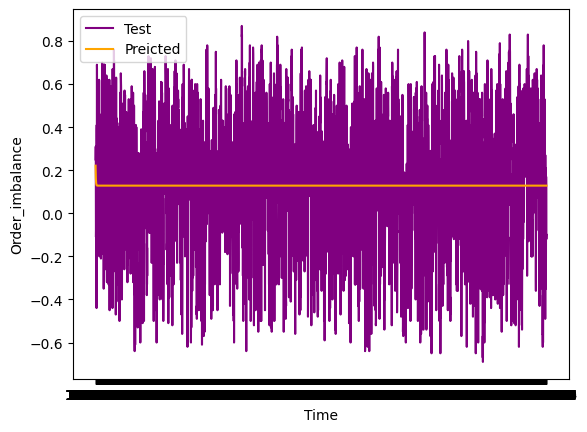

In [9]:
#plt.plot(train['Time'], train['Mid-Price'], label = 'Train')
plt.plot(test['Time'], test['Order_imbalance'], color = 'purple', label = 'Test')
plt.plot(predicted['Time'], predicted['Order_imbalance'], color = 'orange', label = 'Preicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Order_imbalance')
plt.show()

Error Measurements

In [10]:
# Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['Order_imbalance'], predicted['Order_imbalance'])
print("Mean Absolute Error (MAE):", mae)

# Mean Squared Error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['Order_imbalance'], predicted['Order_imbalance'])
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error
rmse = mean_squared_error(test['Order_imbalance'], predicted['Order_imbalance'], squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

# R-squared
from sklearn.metrics import r2_score
r2 = r2_score(test['Order_imbalance'], predicted['Order_imbalance'])
print("R-squared:", r2)

Mean Absolute Error (MAE): 0.25091702845736447
Mean Squared Error (MSE): 0.09287302332327547
Root Mean Squared Error (RMSE): 0.30475075606678237
R-squared: -0.0004446408154714643


c:\Users\timot\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Output to CSV

In [14]:
clean_data = data[data['Order_imbalance'] > 0]

# Calculate the mean and standard deviation of the mid-price
mean_order_imbalance = clean_data['Order_imbalance'].mean()
std_dev_order_imbalance = clean_data['Order_imbalance'].std()

# Determine the thresholds based on a multiple of the standard deviation from the mean mid-price
# Typically, thresholds are set at mean +/- n * standard deviation (where n can be 1, 2, or 3)
n = 1 # This is a common choice for a threshold, but can be adjusted based on backtesting
lower_threshold = mean_order_imbalance - n * std_dev_order_imbalance
upper_threshold = mean_order_imbalance + n * std_dev_order_imbalance

mean_order_imbalance, std_dev_order_imbalance, lower_threshold, upper_threshold

order_imbalance_sig = pd.DataFrame()
order_imbalance_sig['Predicted Train Time'] = predicted['Time']
order_imbalance_sig['Predicted Order_imbalance'] = predicted['Order_imbalance']

# make a function to get the buy/sell signal
def determine_trade_action(price, lower_threshold, upper_threshold):
    if price > upper_threshold:
        return 'Sell'
    elif price < lower_threshold:
        return 'Buy'
    else:
        return 'Hold'

order_imbalance_sig['Buy/Sell'] = order_imbalance_sig['Predicted Order_imbalance'].apply(determine_trade_action, args=(lower_threshold, upper_threshold))

order_imbalance_sig.to_csv('ARIMA Bid-Ask Signal.csv', index=False)

# Clean the data by removing entries with a mid-price of 0
clean_data = data[data['Order_imbalance'] > 0]

# Calculate the mean and standard deviation of the mid-price from the historical data
mean_bid_ask = clean_data['Order_imbalance'].mean()
std_dev_bid_ask = clean_data['Order_imbalance'].std()

# Now, we will calculate alternative thresholds based on the percentiles of the historical mid-prices
# This will help us to set thresholds that are more aligned with the actual data distribution
percentiles = [0.2, 0.8]  # 10th and 90th percentiles for lower and upper thresholds respectively
lower_threshold_percentile = clean_data['Order_imbalance'].quantile(percentiles[0])
upper_threshold_percentile = clean_data['Order_imbalance'].quantile(percentiles[1])

# Load the predicted data to check how it fits with these thresholds
predicted_data = order_imbalance_sig

# Apply the trade action function to the predicted data using the new percentile-based thresholds
predicted_data['Trade_Action_Percentile'] = predicted_data['Predicted Order_imbalance'].apply(
    determine_trade_action, args=(lower_threshold_percentile, upper_threshold_percentile))

# Calculate the alternative thresholds based on a tighter standard deviation multiplier
# We will use a smaller multiplier to see if the predicted values cross these new thresholds
tighter_multiplier = 1  # This can be adjusted as needed
lower_threshold_tighter = mean_order_imbalance - tighter_multiplier * std_dev_order_imbalance
upper_threshold_tighter = mean_order_imbalance + tighter_multiplier * std_dev_order_imbalance

# Apply the trade action function to the predicted data using the new tighter std dev thresholds
predicted_data['Trade_Action_Tighter'] = predicted_data['Predicted Order_imbalance'].apply(
    determine_trade_action, args=(lower_threshold_tighter, upper_threshold_tighter))

# Output the thresholds and the first few rows of the predicted data to see the trade actions
(lower_threshold_percentile, upper_threshold_percentile), (lower_threshold_tighter, upper_threshold_tighter), predicted_data.head()


predicted_data.to_csv('predicted_data_order.csv')